In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import json
import os

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

from analysis import plot # imoporting analysis module enables import from model folder
import analysis.pipelines.population_spikes as ps

%matplotlib inline

RESULT_PATH = "simulation_results"
OUTPUT_PATH = "analysis_results"
overwrite = False

pop_color = plot.pop_color

In [2]:
ps.set_variables(RESULT_PATH=RESULT_PATH, OUTPUT_PATH=OUTPUT_PATH)

process_params = dict(
    fs_ct = 400.,  # Hz. spike count sampling frequency
    fs_fr = 50.,  # Hz. firing rate sampling frequency
    filt_sigma = 20.0  # ms. Gaussian filer sigma
)

In [3]:
# filter = (('short', 'long'), ('rand', 'div'))
# revert_junction = True
filter = ('rand', 'div')
revert_junction = False
exclude = 'baseline'

with open(os.path.join(OUTPUT_PATH, 'trials_ordered.json'), 'r') as f:
    trials_ordered = json.load(f)
trials = ps.get_trials(filter, trials=trials_ordered, revert_junction=revert_junction, exclude=exclude)
print(trials)

['short_rand', 'short_div', 'long_rand', 'long_div', 'ramp_a0_t0.3_rand', 'ramp_a0_t0.3_div', 'ramp_a0_t1.0_rand', 'ramp_a0_t1.0_div', 'ramp_a0_t1.0_down_rand', 'ramp_a0_t1.0_down_div', 'ramp_a0_t3.0_rand', 'ramp_a0_t3.0_div', 'join_a0_t0.3_rand', 'join_a0_t0.3_div', 'join_a0_t1.0_rand', 'join_a0_t1.0_div', 'join_a0_t1.0_quit_rand', 'join_a0_t1.0_quit_div', 'join_a0_t3.0_rand', 'join_a0_t3.0_div', 'fade_a01_t0.1_rand', 'fade_a01_t0.1_div', 'fade_a03_t0.1_div', 'fade_a01_t0.3_rand', 'fade_a01_t0.3_div', 'fade_a03_t0.3_div', 'fade_a01_t1.0_rand', 'fade_a01_t1.0_div', 'fade_a03_t1.0_div', 'fade_a01_t3.0_rand', 'fade_a01_t3.0_div', 'fade_a03_t3.0_div']


### Preprocess data

In [4]:
for trial in trials:
    ps.preprocess(trial, overwrite=overwrite, **process_params)

### Compute STP weights

In [5]:
# tau = 200.  # ms
tau = [40., 60., 100., 160., 250., 400.]  # ms
tau = np.asarray(tau).ravel() / 1000 # to sec

lag_range = [-40, 80]  # ms. range time lags

data = 'fr' # 'fr' low sampling rate or 'ct' high sampling rate

In [6]:
w_stp, fr_tot, lag_fr = zip(*[ps.get_stp_data(trial, tau, lag_range, data=data) for trial in trials])
trial_slice = np.cumsum([0] + list(map(len, fr_tot)))
trial_slice = dict(zip(trials, zip(trial_slice[:-1], trial_slice[1:])))

w_stp = np.concatenate(w_stp, axis=-1)
fr_tot = np.concatenate(fr_tot)
lag_fr = xr.concat(lag_fr, dim='time').stack(target=('population', 'lags'))

### Predict ITN firing rate with PN spike data

In [7]:
root_mean_squared_error = lambda *arg, **kwargs: mean_squared_error(*arg, **kwargs) ** 0.5
error_metrics = {'R2 score': r2_score, 'RMSE': root_mean_squared_error}

population = np.array(ps.ITN_pop_names)

def optimal_error(err_da, opt_idx):
    dim_opt = {dim: xr.DataArray(idx.values, dims='optimal') for dim, idx in opt_idx.items()}
    opt_err = err_da.isel(population=xr.DataArray(range(population.size),
        coords={'optimal': population}), **dim_opt).transpose('optimal', 'metric')
    return opt_err

Regression using only total firing rate input

In [8]:
fr_fr_reg = LinearRegression()
fr_fr_reg.fit(fr_tot[:, None], lag_fr.values)
fr_fr_pred = fr_fr_reg.predict(fr_tot[:, None])

fr_pred_error = xr.DataArray([m(lag_fr.values, fr_fr_pred, multioutput='raw_values') \
    for m in error_metrics.values()], name='prediction error',
    coords=dict(metric=list(error_metrics), target=lag_fr.target)).unstack('target')

fr_optimal_idx = fr_pred_error.sel(metric='RMSE').argmin(dim=['lags'])
fr_optimal_param = xr.Dataset({d: fr_pred_error.coords[d][fr_optimal_idx[d]] for d in ['lags']})
print("Optimal parameters:")
display(fr_optimal_param.to_pandas())
print("Minimum error:")
fr_opt_error = optimal_error(fr_pred_error, fr_optimal_idx)
display(fr_opt_error.to_pandas())

Optimal parameters:


,metric,lags
population,,
FSI,RMSE,80.0
LTS,RMSE,60.0


Minimum error:


metric,R2 score,RMSE
optimal,,
FSI,0.211996,3.843857
LTS,0.745051,3.944530


Regression using STP weights

In [9]:
stp_fr_reg = [LinearRegression() for _ in range(tau.size)]
fr_pred = []
for i, reg in enumerate(stp_fr_reg):
    X = np.column_stack((w_stp[i], fr_tot))
    reg.fit(X, lag_fr.values)
    fr_pred.append(reg.predict(X))

pred_error = xr.DataArray([[m(lag_fr.values, y, multioutput='raw_values') \
    for m in error_metrics.values()] for y in fr_pred], name='prediction error',
    coords=dict(tau=tau, metric=list(error_metrics), target=lag_fr.target)).unstack('target')

In [10]:
param_dims = {'tau': 'Time constant (sec)', 'lags': 'Time lags (ms)'}
optimal_idx = pred_error.sel(metric='RMSE').argmin(dim=list(param_dims))
optimal_param = xr.Dataset({d: pred_error.coords[d][optimal_idx[d]] for d in param_dims})

print("Optimal parameters:")
display(optimal_param.to_pandas())
print("Minimum error:")
opt_error = optimal_error(pred_error, optimal_idx)
display(opt_error.to_pandas())

Optimal parameters:


,metric,tau,lags
population,,,
FSI,RMSE,0.25,0.0
LTS,RMSE,0.10,0.0


Minimum error:


metric,R2 score,RMSE
optimal,,
FSI,0.72558,2.297755
LTS,0.95957,1.570788


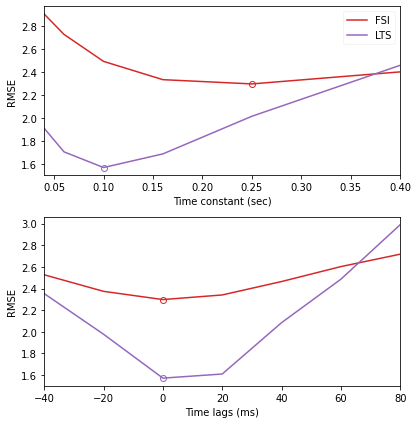

In [11]:
error = pred_error.sel(metric='RMSE')

axs = plt.subplots(len(param_dims), 1, figsize=(6, 3 * len(param_dims)), squeeze=False)[1].ravel()
for ax, (pdm, label) in zip(axs, param_dims.items()):
    for p in population:
        opt_p = optimal_param.sel(population=p)
        err = error.sel(population=p, **{d: opt_p[d] for d in param_dims if d != pdm})
        ax.plot(error[pdm], err, color=pop_color[p], label=p)
        ax.plot(opt_p[pdm], err.sel(**{pdm: opt_p[pdm]}),
                color=pop_color[p], marker='o', markerfacecolor='none')
    ax.set_xlim(error[pdm][[0, -1]])
    ax.set_xlabel(label)
    ax.set_ylabel(error.metric.item())
axs[0].legend(loc='upper right', framealpha=0.2)
plt.tight_layout()
plt.show()

In [12]:
linestyle = {'actual': '-', 'predict': '--'}
opt_pred = []
opt_coef = []
comb_w_stp = []
for p in population:
    opt_p = optimal_param.sel(population=p)
    trg = (p, opt_p.lags.item())
    opt_lag_fr = lag_fr.sel(target=trg).values
    trg_idx = lag_fr.target.to_index().get_loc(trg)
    tau_idx = pred_error.tau.to_index().get_loc(opt_p.tau.item())
    opt_fr_pred = fr_pred[tau_idx][:, trg_idx]
    opt_pred.append([opt_lag_fr, opt_fr_pred])
    opt_reg = stp_fr_reg[tau_idx]
    opt_coef.append(opt_reg.coef_[trg_idx].tolist() + [opt_reg.intercept_[trg_idx]])
    comb_w_stp.append(w_stp[tau_idx])
opt_pred = xr.DataArray(opt_pred, name='optimal prediction', coords=dict(
    population=population, output=list(linestyle), time=lag_fr.time))
opt_coef = xr.DataArray(opt_coef, name='optimal coefficient', coords=dict(
    population=population, coef=['a', 'b', 'c']))
display(opt_coef)

<xarray.DataArray 'optimal coefficient' (population: 2, coef: 3)>
array([[-0.36491471,  7.57408284, -2.08639486],
       [ 0.45054853, -2.42420308,  2.77733371]])
Coordinates:
  * population  (population) <U3 'FSI' 'LTS'
  * coef        (coef) <U1 'a' 'b' 'c'

In [13]:
# # Combine optimal tau and lag for FSI and LTS
# comb_reg = LinearRegression()
# X = np.column_stack((comb_w_stp + [fr_tot]))
# Y = opt_pred.sel(output='actual').values.T
# comb_reg.fit(X, Y)
# comb_pred = comb_reg.predict(X)

# comb_pred_error = xr.DataArray([m(Y, comb_pred, multioutput='raw_values') \
#     for m in error_metrics.values()], name='prediction error',
#     coords=dict(metric=list(error_metrics), population=population)).transpose('population', 'metric')
# display(comb_pred_error.to_pandas())

# opt_pred = xr.DataArray([Y.T, comb_pred.T], name='combined optimal prediction', coords=dict(
#     output=list(linestyle), population=population, time=lag_fr.time))
# opt_coef = xr.DataArray(np.column_stack((comb_reg.coef_, comb_reg.intercept_)),
#     name='combined optimal coefficient', coords=dict(
#     population=population, coef=[f'a{i + 1:d}' for i in range(population.size)] + ['b', 'c']))
# display(opt_coef)

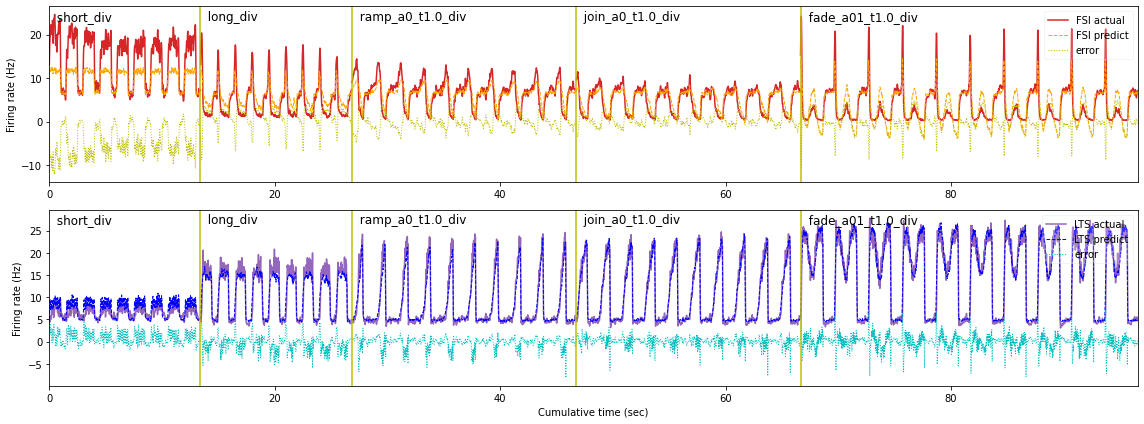

In [14]:
from matplotlib.transforms import blended_transform_factory

pred_clr = {'FSI': 'orange', 'LTS': 'blue'}
err_clr = {'FSI': 'y', 'LTS': 'c'}

# Show all trials
# show_trials = ps.get_trials([], trials=trials)

# Conditions for filtering trials
# trial_filt = (('short', 'long'), 'div')
trial_filt = (('short', 'div'), ('long', 'div'), ('t1.0', 'div'))
exclude = ('a03', 'down', 'quit')
show_trials = ps.get_trials(trial_filt, trials=trials, revert_junction=False, exclude=exclude)

show_slice = {tr: trial_slice[tr] for tr in show_trials}

figsize = (16, 3)
axs = plt.subplots(population.size, 1, figsize=(figsize[0], figsize[1] * population.size), squeeze=False)[1].ravel()
T = 0
for i, (trial, idx) in enumerate(show_slice.items()):
    idx = slice(*idx)
    t = T + opt_pred.time[idx] / 1000
    T = t[-1]
    for p, ax in zip(population, axs):
        Ys = opt_pred.isel(time=idx).sel(population=p)
        for y in opt_pred.output.values:
            clr = pred_clr[p] if y == 'predict' else pop_color[p]
            linewidth = 1 if y == 'predict' else 1.5
            label = None if i else f'{p} {y}'
            ax.plot(t, Ys.sel(output=y), color=clr, linewidth=linewidth,
                    linestyle=linestyle[y], label=label)
        ax.plot(t, Ys.sel(output='predict') - Ys.sel(output='actual'), color=err_clr[p],
                linewidth=linewidth, linestyle=':', label=None if i else 'error')
        if i:
            ax.axvline(x=t[0], color='y')
        trans = blended_transform_factory(ax.transData, ax.transAxes)
        ax.text(t[0], 0.98, '  ' + trial, transform=trans, fontsize='large',
                horizontalalignment='left', verticalalignment='top')
for ax in axs:
    ax.set_xlim([0, T])
    ax.set_ylabel('Firing rate (Hz)')
    ax.legend(loc='upper right', framealpha=0.2)
axs[-1].set_xlabel('Cumulative time (sec)')
plt.tight_layout()
plt.show()

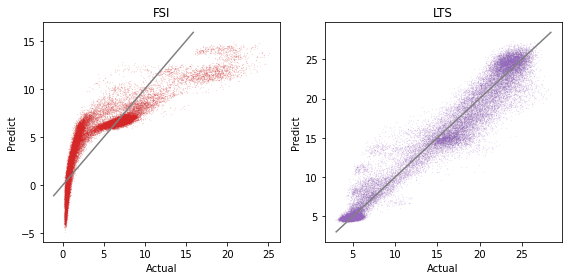

In [15]:
figsize = (4, 4)
axs = plt.subplots(1, population.size, figsize=(figsize[0] * population.size, figsize[1]), squeeze=False)[1].ravel()
for p, ax in zip(population, axs):
    Ys = opt_pred.sel(population=p)
    ax.plot(Ys.sel(output='actual'), Ys.sel(output='predict'), '.',
            color=pop_color[p], markersize=0.1)
    xl, yl = ax.get_xlim(), ax.get_ylim()
    xl = [max(xl[0], yl[0]), min(xl[1], yl[1])]
    ax.plot(xl, xl, 'gray')
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predict')
    ax.set_title(p)
plt.tight_layout()
plt.show()